# Figure 1

This notebook recreates Figure 1 in Rein & Tamayo 2016. The figure illustrates the use of second order variational equations in an $N$-body simulation.

We start by import the REBOUND, numpy and matplotlib packages. 

In [2]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

We setup a planetary system with two Jupiter mass planets. The following function takes that system, integrates it forward in time by 10 orbits and returns the inner planet's $x$ coordinate at the end of the simulation. The $x$ coordinate changes because the planet orbits the star, but also because the planet interacts with the other planet. The function takes the outer planet's initial semi-major axis, $a$, as a parameter. We setup the system using heliocentric coordinates and therefore specify the `primary` attribute when adding particles to REBOUND (by default REBOUND uses Jacobi coordinates which are not supported by variational equations).

In [4]:
def run_sim(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x

We now run this simulation 400 times for different initial $a$ in the range [1.4, 1.7] and store the final $x$ coordinate of the inner planet in the array `x_exact`.

In [5]:
N=400
x_exact = np.zeros((N))
a_grid = np.linspace(1.4,1.7,N)
for i,a in enumerate(a_grid):
    x_exact[i] = run_sim(a)

Next, we create a function that runs an $N$-body simulation including first and second order differential equations. For that we add two sets of variational particles with the `add_variation()` command (one for first order and one for second order). We then initialize the variational particles by varying the outer planet's semi-major axis. After integrating the system forward in time, the function returns the $x$ coordinate of the inner planet as well as the $x$ coordinate of the corresponding variational particles: $\partial x/\partial a$ and $\partial^2 x/\partial a^2$. Note that the variational particles' *position coordinates* are thus unit-less. 

In [6]:
def run_sim_var(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    var_da = sim.add_variation()
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_da.vary(2, "a")
    var_dda.vary(2, "a")
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x, var_da.particles[1].x, var_dda.particles[1].x

We run **one** simulation with variational particles at $a_0=1.56$. We then use the derivates we got from the `run_sim_var()` function to approximate the final position of the inner planet as a function of the outer planet's initial semi-major axis using a Taylor series:
$$x(a) = x(a_0)+\frac{\partial x}{\partial a}\Big|_{a_0} (a-a_0)+\frac 12\frac{\partial^2 x}{\partial a^2}\Big|_{a_0} (a-a_0)^2 + \ldots$$
We do this to both first and second order.

In [7]:
a_0 = 1.56
x, dxda, ddxdda = run_sim_var(a_0)
x_1st_order = np.zeros(N)
x_2nd_order = np.zeros(N)
for i,a in enumerate(a_grid):
    x_1st_order[i] = x + (a-a_0)*dxda
    x_2nd_order[i] = x + (a-a_0)*dxda + 0.5*(a-a_0)*(a-a_0)*ddxdda

Finally, we plot the exact final position that we obtained from running a full $N$-body simulation as well as our approximation near a neighbourhood of $a_0$ which we got from the variational equations. 

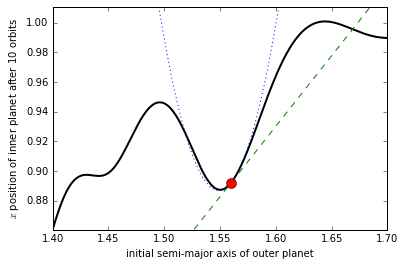

In [8]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlim(a_grid[0],a_grid[-1])
ax.set_ylim(np.min(x_exact),np.max(x_exact)*1.01)
ax.set_xlabel("initial semi-major axis of outer planet")
ax.set_ylabel("$x$ position of inner planet after 10 orbits")
ax.plot(a_grid, x_exact, "-", color="black", lw=2)
ax.plot(a_grid, x_1st_order, "--", color="green")
ax.plot(a_grid, x_2nd_order, ":", color="blue")
ax.plot(a_0, x, "ro",ms=10);
plt.savefig('paper_test1.pdf',bbox_inches='tight');  # Save to file. 